<a href="https://www.kaggle.com/code/mohdmuttalib/isic-2024-skin-cancer-detection-with-3d-tbp?scriptVersionId=193148302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Load data
train_df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
test_df = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
sample_submission = pd.read_csv('/kaggle/input/isic-2024-challenge/sample_submission.csv')

/tmp/ipykernel_18/3953249803.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


In [3]:
# Display basic statistics and info
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [4]:
print(train_df.describe())

              target     age_approx  clin_size_long_diam_mm       tbp_lv_A  \
count  401059.000000  398261.000000           401059.000000  401059.000000   
mean        0.000980      58.012986                3.930827      19.974007   
std         0.031288      13.596165                1.743068       3.999489   
min         0.000000       5.000000                1.000000      -2.487115   
25%         0.000000      50.000000                2.840000      17.330821   
50%         0.000000      60.000000                3.370000      19.801910   
75%         0.000000      70.000000                4.380000      22.304628   
max         1.000000      85.000000               28.400000      48.189610   

         tbp_lv_Aext       tbp_lv_B    tbp_lv_Bext       tbp_lv_C  \
count  401059.000000  401059.000000  401059.000000  401059.000000   
mean       14.919247      28.281706      26.913015      34.786341   
std         3.529384       5.278676       4.482994       5.708469   
min        -9.080269 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


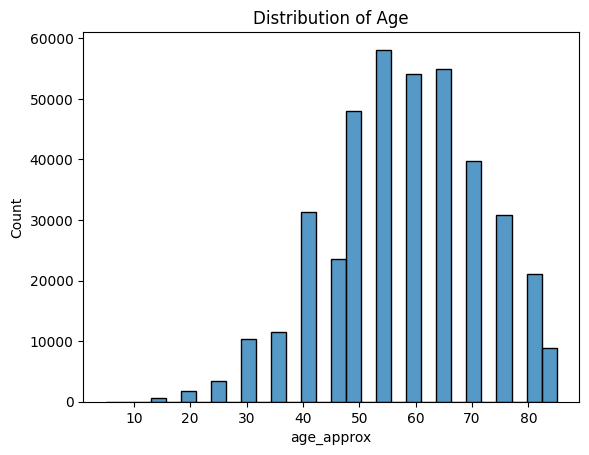

In [5]:
# Distribution of key features
sns.histplot(train_df['age_approx'].dropna(), bins=30)
plt.title('Distribution of Age')
plt.show()

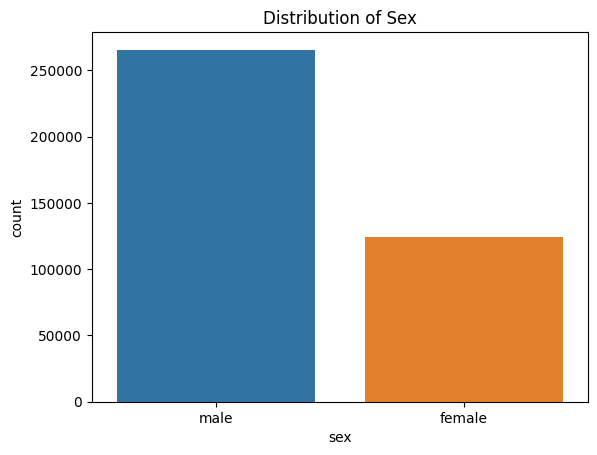

In [6]:
sns.countplot(x='sex', data=train_df)
plt.title('Distribution of Sex')
plt.show()

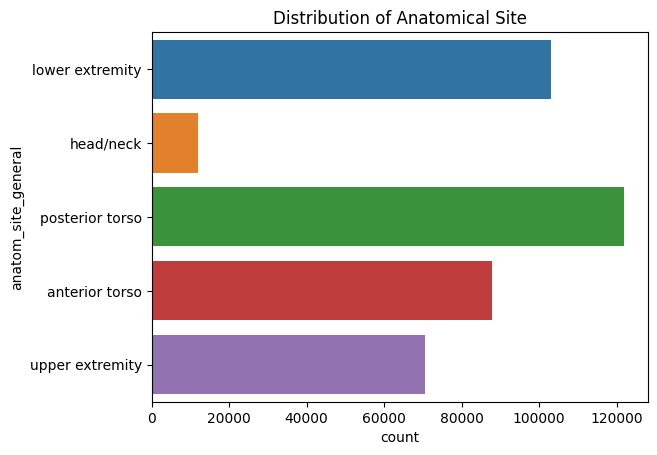

In [7]:
sns.countplot(y='anatom_site_general', data=train_df)
plt.title('Distribution of Anatomical Site')
plt.show()

In [8]:
# Check for missing values
print(train_df.isnull().sum())

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

In [9]:
# Ensure correct data types for columns
train_df['age_approx'] = pd.to_numeric(train_df['age_approx'], errors='coerce')
train_df['clin_size_long_diam_mm'] = pd.to_numeric(train_df['clin_size_long_diam_mm'], errors='coerce')
train_df['tbp_lv_location'] = pd.to_numeric(train_df['tbp_lv_location'], errors='coerce')
train_df['tbp_lv_location_simple'] = pd.to_numeric(train_df['tbp_lv_location_simple'], errors='coerce')
train_df['isic_id'] = pd.to_numeric(train_df['isic_id'], errors='coerce')
train_df['patient_id'] = pd.to_numeric(train_df['patient_id'], errors='coerce')
train_df['target'] = pd.to_numeric(train_df['target'], errors='coerce')
test_df['attribution'] = pd.to_numeric(test_df['attribution'], errors='coerce')
test_df['isic_id'] = pd.to_numeric(test_df['isic_id'], errors='coerce')
test_df['patient_id'] = pd.to_numeric(test_df['patient_id'], errors='coerce')
test_df['anatom_site_general'] = pd.to_numeric(test_df['anatom_site_general'], errors='coerce')
test_df['sex'] = pd.to_numeric(test_df['sex'], errors='coerce')
test_df['image_type'] = pd.to_numeric(test_df['image_type'], errors='coerce')
test_df['anatom_site_general'] = pd.to_numeric(test_df['anatom_site_general'], errors='coerce')
test_df['tbp_tile_type'] = pd.to_numeric(test_df['tbp_tile_type'], errors='coerce')
test_df['tbp_lv_location'] = pd.to_numeric(test_df['tbp_lv_location'], errors='coerce')
test_df['tbp_lv_location_simple'] = pd.to_numeric(test_df['tbp_lv_location_simple'], errors='coerce')

In [10]:
one_hot_encoded_test_df = pd.get_dummies(test_df)

In [11]:
print(train_df.dtypes)

isic_id                         float64
target                            int64
patient_id                      float64
age_approx                      float64
sex                              object
anatom_site_general              object
clin_size_long_diam_mm          float64
image_type                       object
tbp_tile_type                    object
tbp_lv_A                        float64
tbp_lv_Aext                     float64
tbp_lv_B                        float64
tbp_lv_Bext                     float64
tbp_lv_C                        float64
tbp_lv_Cext                     float64
tbp_lv_H                        float64
tbp_lv_Hext                     float64
tbp_lv_L                        float64
tbp_lv_Lext                     float64
tbp_lv_areaMM2                  float64
tbp_lv_area_perim_ratio         float64
tbp_lv_color_std_mean           float64
tbp_lv_deltaA                   float64
tbp_lv_deltaB                   float64
tbp_lv_deltaL                   float64


In [12]:
print(test_df.dtypes)

isic_id                        float64
patient_id                     float64
age_approx                     float64
sex                            float64
anatom_site_general            float64
clin_size_long_diam_mm         float64
image_type                     float64
tbp_tile_type                  float64
tbp_lv_A                       float64
tbp_lv_Aext                    float64
tbp_lv_B                       float64
tbp_lv_Bext                    float64
tbp_lv_C                       float64
tbp_lv_Cext                    float64
tbp_lv_H                       float64
tbp_lv_Hext                    float64
tbp_lv_L                       float64
tbp_lv_Lext                    float64
tbp_lv_areaMM2                 float64
tbp_lv_area_perim_ratio        float64
tbp_lv_color_std_mean          float64
tbp_lv_deltaA                  float64
tbp_lv_deltaB                  float64
tbp_lv_deltaL                  float64
tbp_lv_deltaLB                 float64
tbp_lv_deltaLBnorm       

In [13]:
# Check the distribution of the target variable
print(train_df['target'].value_counts())

target
0    400666
1       393
Name: count, dtype: int64


In [14]:
# Check if there are any positive samples in the target column
if train_df['target'].nunique() == 1 and train_df['target'].unique()[0] == 0:
    print("Warning: The target column contains only zero values. Cannot train a binary classifier without positive samples.")
else:
    # Define the correct lists for numeric and categorical features
    categorical_features = ['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type', 'attribution']
    numerical_features = ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
                          'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
                          'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL',
                          'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
                          'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
                          'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
                          'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']

In [15]:
# Verify that the lists are correct
for col in numerical_features:
        if train_df[col].dtype not in [np.float64, np.int64]:
            print(f"Warning: Column {col} should be numeric but is {train_df[col].dtype}")

for col in categorical_features:
        if train_df[col].dtype not in [object, 'category']:
            print(f"Warning: Column {col} should be categorical but is {train_df[col].dtype}")

In [16]:
# Separate the target variable and features
X = train_df.drop(columns=['target', 'isic_id', 'patient_id'])
y = train_df['target']

In [17]:
# Identify categorical and numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [18]:
# Prepare preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [19]:
# Split data into training and validation sets
#X = train_df.drop(columns=['isic_id', 'target', 'patient_id'])
#y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
# Build the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

In [21]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age_approx',
                                                   'clin_size_long_diam_mm',
                                                   'tbp_lv_A', 'tbp_lv_Aext',
                                                   'tbp_lv_B', 'tbp_lv_Bext',
                                                   'tbp_lv_C', 'tbp_lv_Cext',
                                                   'tbp_lv_H', 'tbp_lv_Hext',
                                                   'tbp_lv_L', 'tbp_lv_Lext',
                                                   'tbp_lv_areaMM2',
                                                   'tbp_lv_area_perim_ratio...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [22]:
# Predict on the validation set
y_val_pred = model.predict_proba(X_val)[:, 1]

In [23]:
# Evaluate the model
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)
print(f"Validation ROC AUC: {roc_auc}")

Validation ROC AUC: 0.9325606937959313


In [24]:
# Calculate pAUC above 80% TPR
pAUC = auc(fpr[tpr >= 0.8], tpr[tpr >= 0.8])
print(f"Partial AUC above 80% TPR: {pAUC}")

Partial AUC above 80% TPR: 0.8753889696354494


In [25]:
# Predict on the test set
X_test = test_df.drop(columns=['isic_id', 'patient_id'])
test_probs = model.predict_proba(X_test)[:, 1]

In [26]:
# Prepare the submission file
sample_submission['target'] = test_probs
sample_submission.to_csv('submission.csv', index=False)